# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import random
import math
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats

# Extract cell activity and trial variables from simulation results

In [2]:
# Initialize arrays of interest variables 
# NOTE: each neuron's activity is a row; column index is trial number

N_PFC_NEURONS = 500
N_MD_NEURONS = 2
N_OUTPUT_NEURONS = 2
TRIAL_TIME = 200

s_trial = 0
t_trial = 4800
n_trials = t_trial - s_trial

rPFC_trials = np.zeros((n_trials, TRIAL_TIME, N_PFC_NEURONS))
task_input = np.zeros((2, n_trials))

# Extract the data

data_dir = "/om2/group/halassa/PFCMD-ali-sabrina/020321_qvals/by_trial"

for i in range(s_trial, t_trial):
    with open(data_dir + "/" + str(i) + ".json") as json_file:
        data = json.load(json_file)
        idx = i - s_trial
                
        rPFC = np.array(data["network_rates"]["r_PFC"])
        rPFC_trials[idx,:,:] = rPFC
        
        trial_task_input = np.array(data["trial_data"]["input"])
        task_input[:,idx] = trial_task_input[:2]


# Compute logistic regression seudo p-squared values for all PFC neurons

## 1. Get an equal number of trials per association levels 
Note the association levels are:
`[.90, .10, .90, .70, .90, .10, .70, .30, .90, .50, .90, .10]`

We will get 50 trials from .90, .70, .30 and .10, and we will get 100 trials from .50.
We only consider trials in the second half of the association level, when learning is finished and activity is more likely to be stable.

In [58]:
SAVE_DIR = '/om2/group/halassa/PFCMD-ali-sabrina/030821_input-like'

def plot_stderr(ax, x, c, l):
    m = np.mean(x, 0)
    stderr = stats.sem(x, 0)
    ax.plot(m, c, label=l)
    ax.plot(m + stderr, 'grey')
    ax.plot(m - stderr, 'grey')

# N_PFC_NEURONS = 500
CUE_TIME = 100

alevel_90_idxs = [0, 2, 4, 8, 10]
alevel_10_idxs = [1, 5, 11]
alevel_70_idxs = [3, 6]
alevel_30_idxs = [7]
alevel_50_idxs = [9]

def sample_trials(alevel_idxs, n_samples):
    trial_per_alevel = 400
    trials_offset = 200 # Only consider the second half of the alevel
    
    trials_to_sample = []
    for n_bin in alevel_idxs:
        trial_s = n_bin * trial_per_alevel + trials_offset
        trial_t = (n_bin + 1) * 400
        trials_to_sample = trials_to_sample + list(range(trial_s, trial_t))
    return random.sample(trials_to_sample, n_samples)
    
prsquareds = []    
for neuron_idx in range(N_PFC_NEURONS):
    
    # Randomly sample trials for analysis from the second half of each alevel
    # We ensure all alevels are equally represented
    
    alevel_90_trials = sample_trials(alevel_90_idxs, 100)
    alevel_10_trials = sample_trials(alevel_10_idxs, 100)
    alevel_70_trials = sample_trials(alevel_70_idxs, 100)
    alevel_30_trials = sample_trials(alevel_30_idxs, 100)
    alevel_50_trials = sample_trials(alevel_50_idxs, 200)
    trials = alevel_90_trials + alevel_10_trials + alevel_70_trials + alevel_30_trials + alevel_50_trials

    # Get cue 1 value and neuron activity for each trial
    # Only consider the activity over the second half of the cue period
    
    cuetime_s = math.floor(CUE_TIME - (CUE_TIME / 2))
    cuetime_t = CUE_TIME
    
    cue = task_input[0, trials]
    neuron_activity = np.mean(rPFC_trials[trials, cuetime_s:cuetime_t, neuron_idx],1)
        
    # Run logistic regression
    try:
        X = np.transpose([np.ones(len(neuron_activity)), neuron_activity])
        y = cue
        model_fit = sm.Logit(y,X).fit(maxiter=50)
        prsquareds.append(model_fit.prsquared)
    except np.linalg.LinAlgError:
        prsquareds.append(0)
    except sm.tools.sm_exceptions.PerfectSeparationError:
        prsquareds.append(1) # Data is linearly separable
        
    if prsquareds[neuron_idx] >= 0.95:
        fig = plt.figure(figsize=(12,5))

        ax1 = fig.add_subplot(1, 2, 1)
        plot_stderr(ax1, rPFC_trials[trials, :, neuron_idx][cue == 0], 'b', 'cue=0')
        plot_stderr(ax1, rPFC_trials[trials, :, neuron_idx][cue == 1], 'r', 'cue=1')
        ax1.axvline(CUE_TIME, color='grey', linestyle=':')
        ax1.legend()
        ax1.set_title(f"Neural activity")
        ax1.set_xlabel("Trial time")
        ax1.set_ylabel("Neuron activity (m +/- sem)")

        ax2 = fig.add_subplot(1, 2, 2)
        ax2.scatter(neuron_activity, cue)
        if prsquareds[neuron_idx] < 1:
            points = sorted(zip(neuron_activity, model_fit.predict(X)) , key=lambda k: [k[1], k[0]])
            points_x, points_y = map(list, zip(*points))
            ax2.plot(points_x, points_y, 'k')
        ax2.set_xlabel("Mean activity in cue (second half)")
        ax2.set_ylabel("Cue")
        ax2.set_title("Logistic regression")
        fig.suptitle(f"Neuron {neuron_idx}, r-squared={prsquareds[neuron_idx]}")
        plt.savefig(f"{SAVE_DIR}/nidx={neuron_idx}.jpg", transparent=False)
        plt.close()

# Replace any -Inf wth 0
np.where(prsquareds == float("-inf"), 0, prsquareds)

# Plot distribution of pseudo r-squared values
plt.hist(prsquareds, bins=50)
plt.title("PFC neurons logistic regression r-squared values")
plt.xlabel("R^2 (cue vs neural activity)")
plt.ylabel("Number of neurons")
plt.savefig(f"{SAVE_DIR}/regression-histogram.jpg", transparent=False)
plt.close()

Optimization terminated successfully.
         Current function value: 0.630343
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.004340
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.467806
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.037788
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.259863
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.357267
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.448159
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.529261
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.549491
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.269092

/cm/shared/openmind/anaconda/3-2019.10/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.352727
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.687995
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.658541
         Iterations 4
         Current function value: 0.000000
         Iterations: 50


/cm/shared/openmind/anaconda/3-2019.10/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.631975
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.143400
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.009149
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.386069
         Iterations 7
         Current function value: 0.000000
         Iterations: 50


/cm/shared/openmind/anaconda/3-2019.10/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.284073
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.381551
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.355405
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.021367
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.562633
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.690366
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.638698
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687889
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692283
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.246572
 

/cm/shared/openmind/anaconda/3-2019.10/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.253030
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.622080
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.666598
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.656613
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.579912
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.639263
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.662431
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.013035
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.681946
         Iterations 4
Optimization termina

/cm/shared/openmind/anaconda/3-2019.10/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.402791
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692568
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.578242
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.361485
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.639311
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.047446
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.658300
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692827
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690084
         Iterations 4
         Current function value: 0.000000
         Iterations: 50


/cm/shared/openmind/anaconda/3-2019.10/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.655968
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.070801
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.672188
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.642590
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.422036
         Iterations 7
         Current function value: 0.000000
         Iterations: 50


/cm/shared/openmind/anaconda/3-2019.10/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.544642
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692051
         Iterations 3
         Current function value: 0.000000
         Iterations: 50


/cm/shared/openmind/anaconda/3-2019.10/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.425245
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.618747
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.650608
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.652029
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580120
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.654314
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.354522
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.306770
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.012612
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.587756
 

/cm/shared/openmind/anaconda/3-2019.10/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.676575
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.554307
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354348
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.524260
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.097010
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.637856
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690428
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.683986
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.249516
         Iterations 9
Optimization termina

/cm/shared/openmind/anaconda/3-2019.10/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.371967
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.591198
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.049024
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.592084
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585403
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689386
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692698
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.581099
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.274855
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.688953
 

/cm/shared/openmind/anaconda/3-2019.10/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.514361
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.601893
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648577
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689064
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.038782
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.676375
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.080054
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.682333
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.608669
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.271354


/cm/shared/openmind/anaconda/3-2019.10/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.633697
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636264
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.675457
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671569
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.559412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.569050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.602211
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.683508
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.004746
         Iterations 22
Optimization terminated successfully.
         Current function value: 0.497277
 

/cm/shared/openmind/anaconda/3-2019.10/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.221655
         Iterations 9
         Current function value: 0.000000
         Iterations: 50


/cm/shared/openmind/anaconda/3-2019.10/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.000005
         Iterations: 50


/cm/shared/openmind/anaconda/3-2019.10/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.173647
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.668199
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.390259
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.322488
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.375921
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.092232
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.015911
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.371467
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.650434
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.620400

/cm/shared/openmind/anaconda/3-2019.10/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.234956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.600362
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.368093
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.684589
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.074431
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.010367
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.679539
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.520896
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.626550
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.455428

/cm/shared/openmind/anaconda/3-2019.10/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.673215
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.373556
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.115687
         Iterations 10
         Current function value: 0.000000
         Iterations: 50


/cm/shared/openmind/anaconda/3-2019.10/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.454053
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.691421
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.575537
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.677839
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.651961
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601723
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477399
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.527914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.522572
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486024
  

/cm/shared/openmind/anaconda/3-2019.10/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.650360
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561292
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.683810
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.670389
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.563982
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.596915
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.672267
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.295219
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.676260
         Iterations 4
Optimization termina

/cm/shared/openmind/anaconda/3-2019.10/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.620509
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691813
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679159
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685694
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.424153
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.415424
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.444985
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.351856
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.565267
         Iterations 6
Optimization terminat

/cm/shared/openmind/anaconda/3-2019.10/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



         Current function value: 0.479582
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.337553
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.606097
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.535879
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.672790
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.681174
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.643076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684867
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.585773
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.568958
         Iterations 7
Optimization ter

/cm/shared/openmind/anaconda/3-2019.10/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ValueError: supplied range of [-inf, 1.0] is not finite

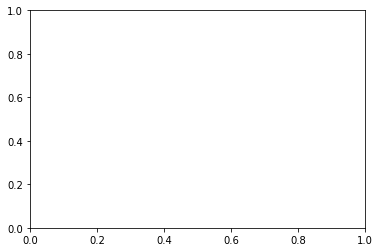